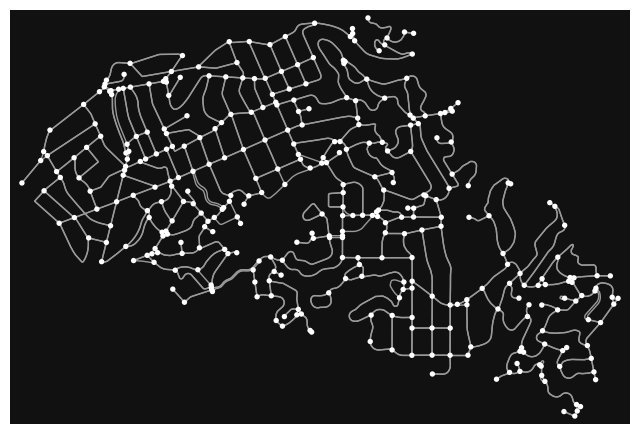

In [1]:
import networkx as nx
import osmnx as ox

ox.__version__


# download/model a street network for some city then visualize it
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
fig, ax = ox.plot_graph(G)




In [2]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

print(D)


DiGraph with 353 nodes and 939 edges


In [3]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()
gdf_edges.head()

print(gdf_nodes.head())

                  y           x  street_count highway  \
osmid                                                   
53017091  37.826250 -122.247604             3     NaN   
53018397  37.824224 -122.247194             3     NaN   
53018399  37.824900 -122.246113             3     NaN   
53018402  37.825406 -122.245338             3     NaN   
53018404  37.825948 -122.244467             3     NaN   

                             geometry  
osmid                                  
53017091  POINT (-122.24760 37.82625)  
53018397  POINT (-122.24719 37.82422)  
53018399  POINT (-122.24611 37.82490)  
53018402  POINT (-122.24534 37.82541)  
53018404  POINT (-122.24447 37.82595)  


In [4]:


# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)



{'n': 353,
 'm': 948,
 'k_avg': 5.371104815864022,
 'edge_length_total': 112028.821,
 'edge_length_avg': 118.17386181434598,
 'streets_per_node_avg': 2.951841359773371,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 270, 4: 47, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09631728045325778,
  2: 0.0,
  3: 0.7648725212464589,
  4: 0.13314447592067988,
  5: 0.0056657223796034},
 'intersection_count': 319,
 'street_length_total': 58076.252,
 'street_segment_count': 497,
 'street_length_avg': 116.85362575452716,
 'circuity_avg': 1.1111605002201332,
 'self_loop_proportion': 0.006036217303822937,
 'clean_intersection_count': 267,
 'node_density_km': 84.06195830904933,
 'intersection_density_km': 75.96533909514656,
 'edge_density_km': 26678.079547631583,
 'street_density_km': 13830.038171019385,
 'clean_intersection_density_km': 63.58227441505997}

In [5]:
import requests

def get_elevation_open_elevation(lat, lon):
    base_url = "https://api.open-elevation.com/api/v1/lookup"
    params = {
        "locations": f"{lat},{lon}",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if "results" in data and data["results"]:
        elevation = data["results"][0]["elevation"]
        return elevation
    else:
        return None

# Example usage
latitude = 37.7749  # Replace with the desired latitude
longitude = -122.4194  # Replace with the desired longitude

elevation = get_elevation_open_elevation(latitude, longitude)
print(f"Elevation: {elevation} meters")


# print(G.nodes(data=True))
print(G)

# Add elevation data to nodes
for node, data in G.nodes(data=True):
    elevation = get_elevation_open_elevation(data['y'], data['x'])
    data['elevation'] = elevation

print("elevation added")

# G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
G = ox.elevation.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
print("done")


Elevation: 16.0 meters
MultiDiGraph with 353 nodes and 948 edges


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

start
MultiDiGraph with 111460 nodes and 295037 edges
elevation
convert
                     y         x  street_count  elevation   highway  ref  \
osmid                                                                      
160374       51.489412  7.405439             4        134       NaN  NaN   
160375       51.490010  7.410145             3        122       NaN  NaN   
160376       51.487569  7.410966             4        123       NaN  NaN   
160379       51.486375  7.404469             4        133  crossing  NaN   
160380       51.485649  7.402769             4        137       NaN  NaN   
...                ...       ...           ...        ...       ...  ...   
11632187037  51.545442  7.375797             4         80       NaN  NaN   
11636041997  51.502826  7.477371             1        120       NaN  NaN   
11636041998  51.502652  7.476689             3        120       NaN  NaN   
11636042000  51.502687  7.477231             1        120       NaN  NaN   
11636042001  51.

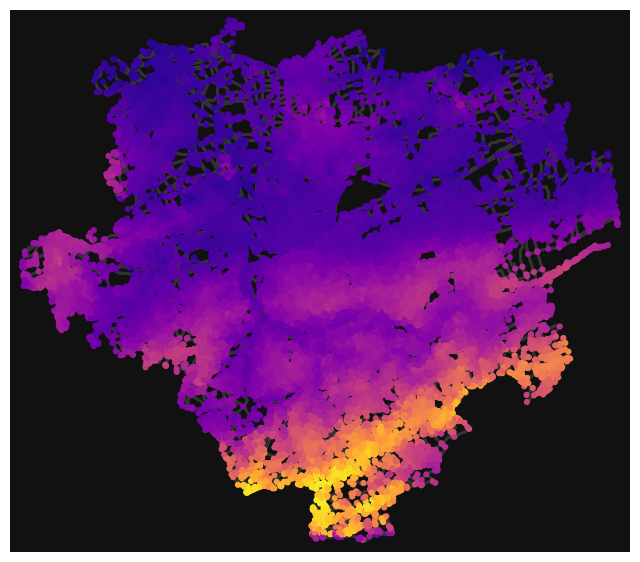

done


In [7]:
import osmnx as ox
import requests
import pandas as pd
import requests
import networkx as nx


def get_elevation_open_elevation(lat, lon):
    base_url = "http://localhost:443/api/v1/lookup?"
    params = {
        "locations": f"{lat},{lon}",
    }

    response = requests.get(base_url, params=params)
    data = response.json() if response is not None and response.content else None
    if 'results' in data and data['results']:
        elevation = data['results'][0]['elevation']
    return elevation

    # if 'highway' in data.tags:
    #     if data.tags['highway'] in ['motorway', 'motorway_link', 'trunk', 'trunk_link']:
    #         return False  # Exclude highways where walking or biking is not allowed
    # elif 'railway' in data.tags:
    #     return False  # Exclude railways (subways/trains)
    # elif 'amenity' in data.tags and data.tags['amenity'] == 'parking':
    #     return False  # Exclude parking lots
    # elif 'foot' in data.tags and data.tags['foot'] == 'no':
    #     return False  # Exclude roads where walking is not allowed
    # elif 'bicycle' in data.tags and data.tags['bicycle'] == 'no':
    #     return False  # Exclude roads where biking is not allowed
    # return True


custom_filter ='["bicycle"!~"no"]["foot"!~"no"]["building"!~"."]["amenity"!~"parking"]["railway"!~"."]'


# Specify the place name for North Rhine-Westphalia, Germany
place_name = "Dortmund, North-Rhine Westphalia, Germany"
print("start")

# Create the graph for NRW
G = ox.graph_from_place(place_name, network_type='all')
# G = nx.DiGraph(G_multi)
# print(G_multi)
# print(G)
# G = ox.graph_from_place(place_name, network_type='all', custom_filter = custom_filter)
print(G)

# Add elevation data to nodes
for node, data in G.nodes(data=True):

    elevation = get_elevation_open_elevation(data['y'], data['x'])
    # data['elevation'] = elevation  
    if elevation is not None:
        data['elevation'] = elevation
    else:
        print(f"Failed to retrieve elevation data for node {node}")

print("elevation")


# Convert the graph data to pandas DataFrames
df_nodes, df_edges = ox.graph_to_gdfs(G)
print("convert")
print(df_nodes)


# Save the DataFrames to CSV files
df_nodes.to_csv('nodes_nrw.csv', index=False)
df_edges.to_csv('edges_nrw.csv', index=False)


G = ox.elevation.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")

print("done")

In [ ]:
# !pip install pyodbc

In [ ]:
import pyodbc
import hashlib
import uuid

# Establish connection to SQL Server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=localhost\\SQLEXPRESS;'
                      'Database=GridDataDB;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()


def create_table_node():
    cursor.execute('''
		CREATE TABLE Node (
            Id UNIQUEIDENTIFIER PRIMARY KEY,
            GeographyValues GEOGRAPHY,
            Elevation INT
            )
                ''')

def create_table_edge():
    cursor.execute('''
		CREATE TABLE Edge (
            Id UNIQUEIDENTIFIER PRIMARY KEY,
            ShoelaceForward DECIMAL(18, 0),
            ShoelaceBackward DECIMAL(18, 0),
            Tags TEXT,
            GeoLocations GEOGRAPHY,
            SourceNodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edge(Id),
            TargetNodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edge(Id),
            Reversed BIT NULL,
            Cost DECIMAL(18, 0),
            OneWay BIT NULL            
			)
               ''')

def create_table_incident_edges():
     cursor.execute('''
        CREATE TABLE IncidentEdges (
            node_id UNIQUEIDENTIFIER,
            edge_id UNIQUEIDENTIFIER,
            NodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Nodes(Id),
            EdgeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edges(Id),
            PRIMARY KEY (NodeId, EdgeId)
        )
    ''')

def check_id_exists(cursor, node_id, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE Id = ?", node_id)
    count = cursor.fetchone()[0]
    return count > 0

def check_ids_exist(cursor, id1, id2, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE NodeId = ? AND EdgeId = ?", (id1, id2))
    count = cursor.fetchone()[0]
    return count > 0


def generate_id(osmid_tuple):
    if isinstance(osmid_tuple, int):
        int_bytes = osmid_tuple.to_bytes((osmid_tuple.bit_length() + 7) // 8, byteorder='big', signed=False)
        sha256_digest = hashlib.sha256(int_bytes).digest()
        uuid_bytes = sha256_digest[:16]
        return uuid.UUID(int=osmid_tuple)
    else:
        osmid_str = ','.join(str(osmid) for osmid in sorted(osmid_tuple)).encode()
        sha256_digest = hashlib.sha256(osmid_str).digest()
        edge_uuid = uuid.UUID(bytes=sha256_digest[:16])  # Convert the first 16 bytes to UUID
        return edge_uuid
    

# Query to get all tables
tables = cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")

# Fetch all table names
table_names = [table[0] for table in tables.fetchall()]

# Print the list of table names
if table_names == []:
    print('Table not found!')
    create_table_node()
    create_table_edge()
    create_table_incident_edges()
    print("create all")
else:
    if "Edge" not in table_names:
        create_table_edge()
        print("edge")
    if "Node" not in table_names:
        crate_table_node()
        print("node")
    if "IncidentEdges" not in table_names:
        create_table_incident_edges()
        print("incident edges")
    

print("done")

nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))


# Insert node data into the Nodes table
cursor = conn.cursor()
for node in nodes:
    node_id = generate_id(node[0]) # Generate a new UUID for each node
    if not check_id_exists(cursor, node_id, "Node"):
        point = f"POINT({node[1]['x']} {node[1]['y']})"
        if(node[1]['x'] > 90 or node[1]['x'] < -90 or node[1]['y'] > 90 or node[1]['y'] < -90):
            print(point)
        cursor.execute('''
            INSERT INTO Node (Id, GeographyValues, Elevation)
            VALUES (?, geography::STGeomFromText(?, 4326), ?)
        ''', (node_id, point, node[1].get('elevation', None)))

print("commit nodes")
conn.commit()


# Insert edge data into the Edges table
for source_node_id, target_node_id, edge_attrs in edges:
    node_not_inserted = False
    edge_id = generate_id(edge_attrs.get('osmid',None))
    source_node_id = generate_id(source_node_id)
    target_node_id = generate_id(target_node_id)
    # edge_id = generate_edge_id(edge_id)
    # print(edge_attrs.get('geometry'))
    # print(source_node_id)
    highway_tags = edge_attrs.get('highway', [])
    if not check_id_exists(cursor, edge_id, "Edge"):
        cursor.execute('''
            INSERT INTO Edge (Id, SourceNodeId, TargetNodeId, Cost, Tags, Oneway, Reversed)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
        edge_id,
        source_node_id,
        target_node_id,
        edge_attrs.get('length', None),
        ', '.join(highway_tags) 
          if (isinstance(highway_tags, list) and 
                    all(isinstance(item, str) and 
                        len(item) > 1 for item in highway_tags)) 
              else highway_tags,
        1 if edge_attrs.get('oneway', None) else 0, 
        1 if edge_attrs.get('reversed', None) else 0
        ))
    # else:
    #     node_Not_inserted = True
    #     print(edge_id)
    
    if edge_attrs.get('geometry') is not None:
        geolocations = edge_attrs.get('geometry')
        if isinstance(geolocations, str):
            # Convert WKT string to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
            ''', (geolocations, edge_id))
        else:
            # Convert WKT representation of geometry to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
            ''', (geolocations.wkt, edge_id))

    
    if not check_ids_exist(cursor, source_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (source_node_id, edge_id))
    else:
        if node_not_inserted:
            print("error")
    if not check_ids_exist(cursor, target_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (target_node_id, edge_id))
conn.commit()
print("commit edges")

# Close the cursor and connection
cursor.close()
conn.close()
print("all done")


done
commit nodes
00000000-0000-0000-0000-000001d8acaf
00000000-0000-0000-0000-000001716f95
00000000-0000-0000-0000-00002db37d9f
00000000-0000-0000-0000-000007ca69a5
00000000-0000-0000-0000-0000019bee1a
00000000-0000-0000-0000-0000019bee1a
00000000-0000-0000-0000-000001cd8890
00000000-0000-0000-0000-000001cd8890
00000000-0000-0000-0000-0000017f70b0
00000000-0000-0000-0000-0000003dba37
00000000-0000-0000-0000-000007ba732f
00000000-0000-0000-0000-000007ba7314
00000000-0000-0000-0000-000007ba7314
00000000-0000-0000-0000-000007ba7314
00000000-0000-0000-0000-00001d46ca85
00000000-0000-0000-0000-00001d46ca85
00000000-0000-0000-0000-0000250a7cd3
00000000-0000-0000-0000-00003d2b88da
00000000-0000-0000-0000-00003d341770
00000000-0000-0000-0000-00000162cc85
00000000-0000-0000-0000-0000004cfddf
00000000-0000-0000-0000-0000004cfddf
00000000-0000-0000-0000-0000004cfddf
00000000-0000-0000-0000-00000095f99f
00000000-0000-0000-0000-000012eb0a14
00000000-0000-0000-0000-00002584a781
00000000-0000-0000-0